In [3]:
def print_logprob(response):
 """
 Print log probabilities for each token in the response
 """
 if response.candidates and response.candidates[0].logprobs_result:
   logprobs_result = response.candidates[0].logprobs_result
   for i, chosen_candidate in enumerate(logprobs_result.chosen_candidates):
     print(
       f"Token: '{chosen_candidate.token}' ({chosen_candidate.log_probability:.4f})"
       )
     print("-" * 20)

In [4]:
import json
import re
from loguru import logger
from google import genai
from google.genai import types as genTypes
from PIL import Image

from vif.models.detection import SegmentationMask
from vif.prompts.identification_prompts import SEGMENTATION_PROMPT
from vif.utils.detection_utils import parse_segmentation_masks
from vif.utils.image_utils import encode_image


def get_segmentation_masks(
    image: Image.Image,
    client: genai.Client,
    features,
    model,
) -> tuple[list[SegmentationMask, list]]:
    encoded_image = encode_image(image=image)

    logger.info(f"Getting masks for features : {','.join(features)}")

    contents = [
        genTypes.Content(
            role="user",
            parts=[
                genTypes.Part.from_bytes(
                    mime_type="image/png",
                    data=encoded_image,
                ),
                genTypes.Part.from_text(
                    text=SEGMENTATION_PROMPT.format(
                        labels=", ".join(['"' + feature + '"' for feature in features])
                    )
                ),
            ],
        ),
    ]

    response = client.models.generate_content(
        model=model,
        contents=contents,
        config=genTypes.GenerateContentConfig(
            temperature=0.5,
            thinking_config=genTypes.ThinkingConfig(thinking_budget=0),
            response_logprobs=True,
            logprobs=1,
        ),
    )

    pattern = r"```(?:\w+)?\n([\s\S]+?)```"
    logger.info("LLM segmentation response: " + str(response.text))
    id_match = re.search(pattern, response.text)
    json_res = id_match.group(1)

    token_data = response.usage_metadata
    detected = json.loads(json_res)
    seg_masks = parse_segmentation_masks(detected, image.height, image.width)

    return seg_masks, token_data, response

2025-09-16 13:56:32.704 | INFO     | vif.utils.caching:instantiate_cache:26 - seg_cache cache loaded


In [ ]:
import math


def get_mask_seg_logbprob(response):
    """
    Print log probabilities for each token in the response
    """
    
    probs = []
    if response.candidates and response.candidates[0].logprobs_result:
        logprobs_result = response.candidates[0].logprobs_result
        i = 0
        while i< len(logprobs_result.chosen_candidates):
            chosen_candidate = logprobs_result.chosen_candidates[i]
            if "{" in chosen_candidate.token :
                current_detection = {}
                i+=1
                current_string =""
                while "}" not in chosen_candidate.token:
                    chosen_candidate = logprobs_result.chosen_candidates[i]
                    current_string += chosen_candidate.token
                    if 'box_2d": [' in  current_string:
                        i+=1
                        chosen_candidate = logprobs_result.chosen_candidates[i]
                        box_prob_l = []
                        while  "]" not in chosen_candidate.token:
                            if chosen_candidate.token.isdigit():
                                box_prob_l.append(chosen_candidate.log_probability)
                            i+=1
                            chosen_candidate = logprobs_result.chosen_candidates[i]
                        current_detection["box_prob"] = math.exp(sum(box_prob_l)/len(box_prob_l))
                        current_string = ""
                    elif 'label": "' in current_string:
                        i+=1
                        chosen_candidate = logprobs_result.chosen_candidates[i]
                        cur_label = ""
                        while '"' not in chosen_candidate.token:
                            cur_label+=chosen_candidate.token
                            i+=1
                            chosen_candidate = logprobs_result.chosen_candidates[i]
                        current_detection["label"] = cur_label
                        current_string = ""
                    elif 'mask": "' in current_string:
                        i+=1
                        chosen_candidate = logprobs_result.chosen_candidates[i]
                        seg_prob_l = []
                        while '"' not in chosen_candidate.token:
                            if "<" in chosen_candidate.token and not "<start_of_mask>" in chosen_candidate.token:
                                seg_prob_l.append(chosen_candidate.log_probability)
                            i+=1
                            chosen_candidate = logprobs_result.chosen_candidates[i]
                        current_detection["seg_prob"] = math.exp(sum(seg_prob_l)/len(seg_prob_l))
                        current_string = ""
                    else:
                        i+=1    
                probs.append(current_detection)
            i+=1
    return probs

In [6]:
from vif.utils.renderer.tex_renderer import TexRenderer
from PIL import Image
from google import genai
from google.genai import types as genTypes
import os
# APIs used
gclient = genai.Client(
    api_key=os.environ.get("GOOGLE_API_KEY"),
    http_options=genTypes.HttpOptions(api_version="v1alpha"),
)

# Models used
temperature=0.3,
visual_model="gemini-2.5-flash"

2025-09-16 14:16:20.099 | INFO     | __main__:get_segmentation_masks:22 - Getting masks for features : node at the bottom left outside and on the left side of the red zone,node at the bottom of the blue zone,node in both the green and the blue zone
2025-09-16 14:16:25.548 | INFO     | __main__:get_segmentation_masks:53 - LLM segmentation response: ```json
[
  {"box_2d": [693, 627, 750, 683], "mask": "", "label": "node at the bottom of the blue zone"},
  {"box_2d": [390, 473, 440, 530], "mask": "", "label": "node in both the green and the blue zone"},
  {"box_2d": [487, 153, 550, 220], "mask": "", "label": "node at the bottom left outside and on the left side of the red zone"}
]
```

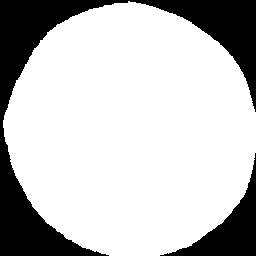
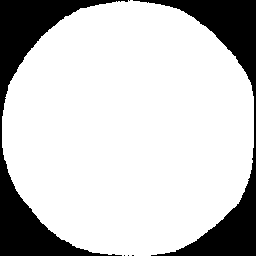
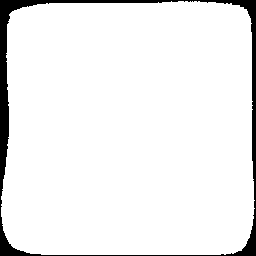

In [53]:
colnodes = Image.open("notebooks/protos/images/node_removed.png")
colnode_seg,token_data,response = get_segmentation_masks(
    colnodes,
    gclient,
    ["node at the bottom left outside and on the left side of the red zone","node at the bottom of the blue zone","node in both the green and the blue zone"],
    visual_model,
)

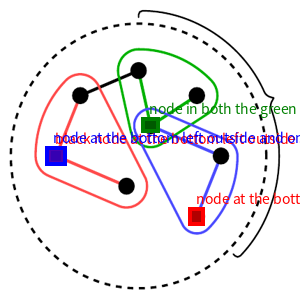

In [54]:
from vif.utils.detection_utils import plot_segmentation_masks


plot_segmentation_masks(colnodes,colnode_seg)

In [55]:
probs = get_mask_seg_logbprob(response)
probs

[{'box_prob': 0.4922549026418142,
  'seg_prob': 0.33150219618854926,
  'label': 'node at the bottom of the blue zone'},
 {'box_prob': 0.8588610264524017,
  'seg_prob': 0.3782247782093934,
  'label': 'node in both the green and the blue zone'},
 {'box_prob': 0.7105479882929299,
  'seg_prob': 0.3822604497222491,
  'label': 'node at the bottom left outside and on the left side of the red zone'}]

In [51]:
import math


[{'full_prob': (prob["box_prob"] + prob["seg_prob"])/2,'label': prob["label"]} for prob in probs]

[{'full_prob': 0.5832457624047411,
  'label': 'node at the bottom left that is outside of the red zone'},
 {'full_prob': 0.5479245919059068,
  'label': 'node at the bottom of the blue zone'},
 {'full_prob': 0.5973341506958056,
  'label': 'node in both the green and the blue zone'}]